# Huspriser

Som nævnt, har du fået betroet opgaven at skrive en machine learning algoritme der kan forudsiger priser på huse. Før vi går i gang, skal vi have hentet nogle "pakker". Tænk på det som nogen der har skrevet noget kode vi kan importere, så vi ikke skal gøre alting fra bunden. Når du kører cellen herunder, importerer og installere den automatisk det vi skal bruge.

In [125]:
# Importer pakker der skal bruges
%pip install -q numpy matplotlib scikit-learn lightgbm graphviz ipython

# Data
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Sklearn: et librabry med en masse funtioner vi bruger i Machine Learning
import sklearn as sklearn

# Graphviz - Pakke der kan visualisere decision trees
from IPython.display import SVG, display
from graphviz import Source

# LightGBM - pakke til at køre decision tree
import lightgbm as lgb
from lightgbm import early_stopping

Note: you may need to restart the kernel to use updated packages.


## Inspicer dataen

Først vil vi gerne undersøge hvilken data vi har med at gøre. 

In [126]:
data = np.genfromtxt('HousingPrices_selected.csv', delimiter=',', names=True, dtype=None, encoding=None)

variabler = data.dtype.names
input_variabler = [v for v in variabler if v != 'Salgspris']
input_data = np.column_stack([data[v] for v in input_variabler])
truth_data = data['Salgspris']

# Print first 5 rows with names
print(" | ".join(variabler))
for row in data[:5]:
    print(" | ".join(str(row[v]) for v in variabler))

Postnummer | Husnummer | Kvadratmeter | Grundareal | Byggeår | Afstand_skole | Afstand_supermarked | Salgspris
4953.0 | 9.0 | 97 | 949.0 | 1942.0 | 5425.42 | 5551.78 | 1050000
2300.0 | 12.0 | 86 | 0.0 | 2006.0 | 1045.23 | 132.97 | 1352500
2300.0 | 12.0 | 86 | 0.0 | 2006.0 | 1045.23 | 132.97 | 3500000
2300.0 | 16.0 | 95 | 0.0 | 2007.0 | 1017.53 | 153.93 | 3463432
2300.0 | 18.0 | 73 | 0.0 | 2007.0 | 1004.49 | 166.23 | 2700000


# Decision Tree

Et decision tree er bygget op af lag og grene. Ved hver gren stiller den et spørgsmål, og bevæger sig ned i det næste lag baseret på om spørgsmålet er sandt eller falsk. Og ved at lære af en masse data, kan den finde ud af hvilke spørgsmål der er bedst at stille.

### Parameter
For et decision tree kan vi justede på hvor mange lag der skal være i vores træ, altså hvor mange lag af spørgsmål der må stilles. Vi kan justere på den parameter herunder

In [127]:
DT_N_lag = 2                # Hvor mange lag der er i træet

Her bygger og træner vi modellen og bruger Graphviz til at visualisere det.

Max dybde af træet: 2


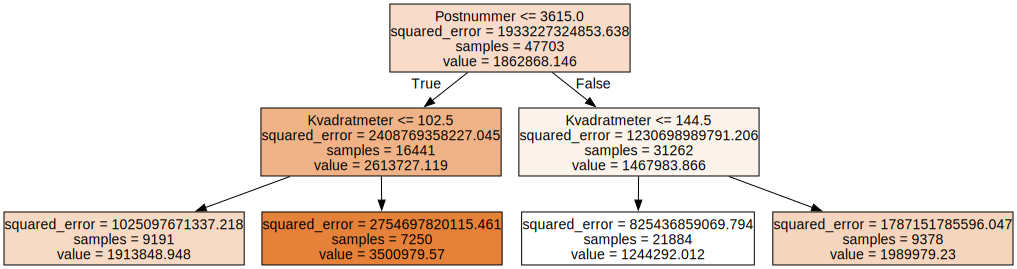

In [128]:
# Her bliver modellen trænet på data
estimator = sklearn.tree.DecisionTreeRegressor(max_depth=DT_N_lag, min_samples_leaf = 20,random_state=42)

estimator.fit(input_data, truth_data)   # Dette er den "magiske" linje - her optimerer Machine Learning algoritmen sine interne vægte til at give bedste svar

# laver visuel graf af træet
graph = Source(sklearn.tree.export_graphviz(estimator, out_file=None, feature_names=input_variabler, filled=True, max_depth=50))                     
print("Max dybde af træet:", estimator.get_depth()) 
display(SVG(graph.pipe(format='svg')))

### Spørgsmål:

- Inspicer træet. Forstår du/I, hvad de forskellige tal betyder?
  Hvilken type bolig passer flest eksempler ned i, i lag 2? Hvad er algoritmens bud på deres pris (dvs. gennemsnitsprisen)?
- Prøv at ændre på hvor mange lag der er i træet fra 2 til 3.
  Hvilken parameter bliver brugt oftest til at opdele data? Tror du/I at den så er den vigtigste parameter?
  Kan du/I ud fra træet sige mere generelt hvilke parametre der betyder mest for prisen? Hvilke betyder mindst?

## Boosted Decision Tree

Nu hvor vi har set hvordan træet virker, vil vi gerne prøve at forudsige værdien på huse som vi ikke kender salgsprisen på.
Som vi har set, kan det være svært at minimere vores 'loss function'. En måde at forbedre på er ved at køre boosted decision trees, hvilket vil sige at vi kører flere træer, hvor den hver gang lærer af fejlene fra det forrige træ, og på den måde bliver "boostet" for hvert træ den laver. Herunder kan vi ændre hvor mange gange den må "booste", altså hvor mange træer den må lave og lærer af.

In [129]:
boosting_rounds = 10        # Hvor mange runder af træer den må lave og lærer af

vi bruger train_test_split til at splitte data i et træningssæt og et testsæt.
træningssættet bruges til at træne modellen, hvor modellen får salgspriserne at vide.
testsættet bruges til at give den trænede model data uden salgspriser, som den så skal forudsige, men hvor vi stadig kender svaret

In [130]:
data_træning, data_test, sande_pris_træning, sande_pris_test = \
    sklearn.model_selection.train_test_split(input_data, truth_data, test_size=0.25, random_state=42)

In [131]:
# Vi giver træningsdata og testsdata til LightGBM:
lgb_train = lgb.Dataset(data_træning, sande_pris_træning)
lgb_test  = lgb.Dataset(data_test,  sande_pris_test, reference=lgb_train)
    
# Her sætter vi "Hyper parametre" for modellen.
hyper_parameters = {
    'objective': 'regression',               # regression bruges når vi gerne vil forudsige en kontinuert værdi
    'metric': 'mse',                         # hvilken 'fejl' den skal bruge til at optimere efter. 
    'num_boost_round': boosting_rounds,      # Hvor mange "runder" den må køre for at optimere
    'verbose': -1}

# Træn modellen:
gbm_test = lgb.train(hyper_parameters, lgb_train, valid_sets=lgb_test, callbacks=[early_stopping(15)])  
                                                    
# Lav forudsigelser med den trænede model
forudsagte_pris = gbm_test.predict(data_test, num_iteration=gbm_test.best_iteration)    

Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's l2: 9.71726e+11


In [132]:
# Denne function laver plots til at vise hvor godt algoritmen klarer sig.
def plotting(sande, forudsagte):

    r2 = sklearn.metrics.r2_score(sande, forudsagte) 
    MAE = sklearn.metrics.mean_absolute_error(sande_pris_test, forudsagte_pris)
    MSE = sklearn.metrics.mean_squared_error(sande_pris_test, forudsagte_pris)

    residuals = forudsagte - sande
    uncertainty = np.std(residuals)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    mio = 1e6 # vi dividerer med 10^6 for at få tallene i hele milioner.

    ###---- VENSTRE PLOT -----###
    ax = axes[0]
    ax.hist((forudsagte - sande)/mio, bins = 100)
    ax.text(0.02, 0.98, f"Usikkerhed: {uncertainty:,.0f} kr.",
    transform=ax.transAxes, va='top', ha='left',
    bbox=dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8))
    ax.set_xlabel('Residual')
    ax.set_ylabel('counts')
    ax.set_title('Histogram residualer')

    ###---- HØJRE PLOT -----###
    ax = axes[1]
    ax.scatter(sande/mio, forudsagte/mio, alpha=0.5, s=10)
    ax.plot([np.min(sande/mio), np.max(sande/mio)], [np.min(sande/mio), np.max(sande/mio)], 'r--', label='Perfekt forudsigelse')
    ax.grid(True)
    ax.set_ylabel('Forudsagte pris (mio)')
    ax.set_xlabel('Sande pris (mio)')
    ax.text(0.02, 0.98, f"MAE: {MAE:,.0f}\nMSE: {MSE:,.0f}\nR²: {r2:,.3f}",
    transform=ax.transAxes, va='top', ha='left',
    bbox=dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8))
    ax.legend()
    ax.set_title('Sande vs forudsagte pris')

    plt.tight_layout()
    plt.show()


Nu vil vi gerne inspicere hvor god vores model er til at forusige på data hvor den ikke kender prisen. Det venstre plot viser residualerne, altså sande værdi - forudsagte værdi. Det højre plot er sande værdi vs forudsagte værdi. 

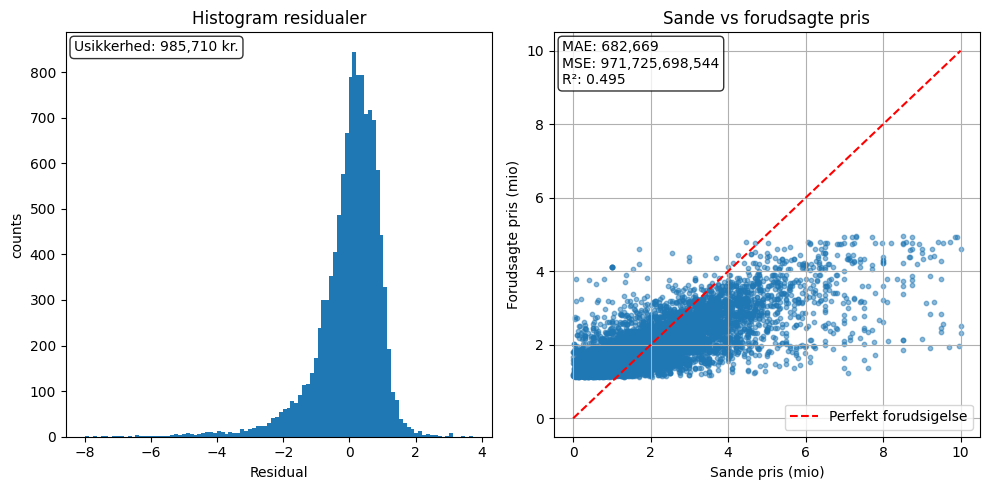

In [133]:
plotting(sande_pris_test, forudsagte_pris)

### Spørgsmål:

- Prøv at ændre på hvor mange gange gange den må booste, ved at ændre boosting_rounds fra 1 til 10, 100 eller 1000. Kan du se en forbedring?
- Hvor har modellen sværest ved at forudsige prisen? Er det ved de billigste huse, de dyreste, eller dem i mellem? Hvad kan det være? Hvilke huse tror du der er mest data på?

# Neurale Netværk

Neurale Netværk (NN) kommer fra at opbygningen af det, minder om den måde vores neuroner i hjernen snakker sammen på. På samme måde som et decision tree er der forskellige lag og vi kan styre hvor mange lag der er, men nu er det ikke kun sandt eller falsk, i stedet fungerer noderne som knapper der kan fintunes. 

Neurale netværk er mere følsomme overfor det data vi giver dem. Den fungerer bedst hvis resultatet er værdier mellem 0 og 1. Derfor bruger vi en funktion til at skalere vores data, kaldet StandardScaler

In [134]:
scaler = sklearn.preprocessing.StandardScaler()

data_træning = scaler.fit_transform(data_træning)
data_test = scaler.transform(data_test)

I et neuralt netværk kan vi justere på hvor mange lag og hvor mange noder hvert lag skal have:

In [135]:
layer_one   = 64            # Her definerer vi hvor mange lag der skal være, og hvor mange 'neuroner' 
layer_two   = 32            # hvert lag skal have. Prøv at ændre på antal neuroner 
layer_three = 16            # for at forbedre din model
layer_four  = 8
layer_five  = 4
layer_six   = 2

In [136]:
# Her definerer og træner vi modellen
mlp = sklearn.neural_network.MLPRegressor(loss='squared_error',hidden_layer_sizes=(layer_one, layer_two, layer_three, layer_four, layer_five, layer_six), 
max_iter=2000, early_stopping=True, random_state=42)
mlp.fit(data_træning, sande_pris_træning)  

# Her giver vi den trænede model test data som den ikke har set før, og beder om at forudsige prisen
forudsagte_pris = mlp.predict(data_test)  

Igen plotter vi for at se hvor godt vores Neurale Netværk klarer sig

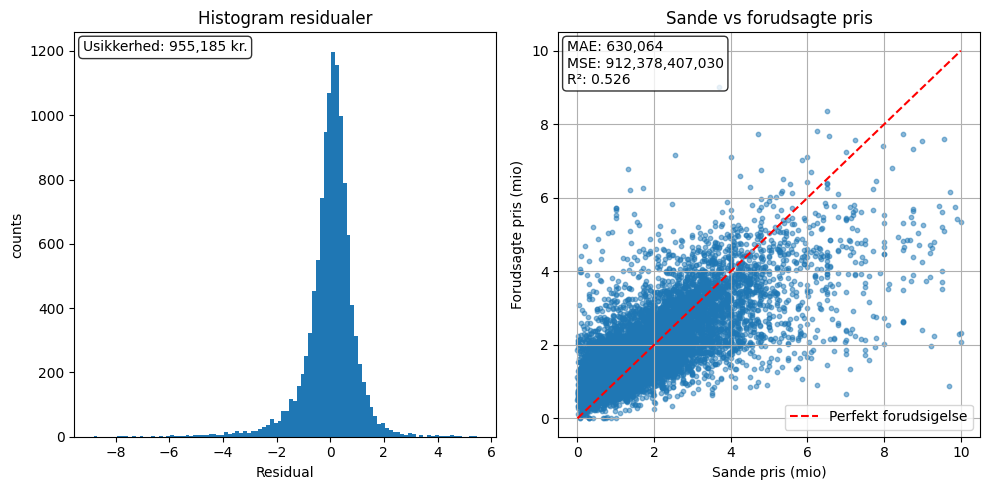

In [137]:
plotting(sande_pris_test, forudsagte_pris)

### Spørsgmål:
- Prøv at justere på antal neuroner i det neurale netværk - Kan du mindske usikkerheden?
- Hvilken algoritme klarer sig bedst? Boosted decision tree eller neutralt netværk?